In [101]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Add some convenience functions to Pandas DataFrame.
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.3f}'.format
def mask(df, key, function):
  """Returns a filtered dataframe, by applying function to key"""
  return df[function(df[key])]

def flatten_cols(df):
  df.columns = [' '.join(col).strip() for col in df.columns.values]
  return df

pd.DataFrame.mask = mask
pd.DataFrame.flatten_cols = flatten_cols

In [31]:
!pip install git+git://github.com/altair-viz/altair.git
import altair as alt
alt.data_transformers.enable('default', max_rows=None)
#alt.renderers.enable('colab')

  Cloning git://github.com/altair-viz/altair.git to /tmp/pip-req-build-92hu54ci
  Running command git clone -q git://github.com/altair-viz/altair.git /tmp/pip-req-build-92hu54ci
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for altair: filename=altair-4.2.0.dev0-py3-none-any.whl size=729978 sha256=cdb3ae941b1935c84f0d390cb28fcd1f0ee1e1b389f55f83ee5c73c249c2369f
  Stored in directory: /tmp/pip-ephem-wheel-cache-pruthuc7/wheels/06/13/e0/5bd72c969fe3954ee1561739e5c58e2ddfe5c10fcdffb12faa
Successfully built altair


DataTransformerRegistry.enable('default')

One of the most important architechtural decisions was to use Google DataPrep (which is a manual version of Dataflow and Apache Beam) to clean the data and get it into Google BigQuery.  This decision has mainly to do with the fact that this technology is what my company uses since Google has given us 100K British pounds worth of Cloud Credits.  So all of our infrastructure is in the Google Cloud and this is what I must learn how to use most effectively and thus I'm doing this here.  This notebook is running in the Google Cloud AI lab but aside from the BigQuery SQL part of it, the rest of the code should also run in IBM Watson.  However, in this case the dataframes that I am creating with BigQuery must first be saved as CSV files to some local folder.   

In [2]:
%%bigquery df
SELECT
  pov.Geographic_Area,
  pov.City,
  poverty_rate,
  percent_completed_hs
FROM
  police_brutality.PercentagePeopleBelowPovertyLevel AS pov
JOIN
  police_brutality.PercentOver25CompletedHighSchool AS high
ON
  pov.Geographic_Area=high.Geographic_Area
  AND pov.City=high.City
WHERE
  poverty_rate IS NOT NULL;

In [3]:
df.describe()

,poverty_rate,percent_completed_hs
count,29128.000000,29125.000000
mean,16.443954,85.730376
std,13.177842,11.874520
min,0.000000,0.000000
25%,7.100000,81.000000
50%,13.700000,88.400000
75%,22.500000,93.500000
max,100.000000,100.000000


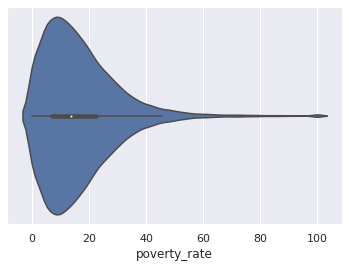

In [6]:
sns.set_style("whitegrid")
sns.set(font="DejaVu Sans")
ax = sns.violinplot(data=df, x='poverty_rate', inner='box', orient='h')

Here we see that most of the data lies between 0 and 60; thus I will use clipping at 60 because there simply aren't enough examples above 60 percent poverty.  It is clearly important not to throw away "outliers" as they might be important for police shootings and protests. So what I will do here is rescale the data so it lies between 0 and 1, where anything at 60% poverty or above will map to 1. If all features lie above 0 we will be able to perform a NMF non-negative matrix factorization; this has been shown to perform better than PCA for tree based models and in some other important cases (https://arxiv.org/abs/1401.5226) ...more on that in later excercises.  

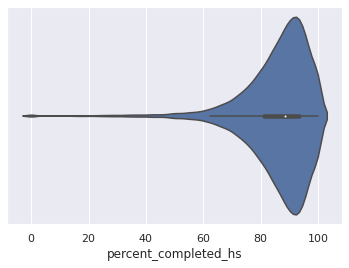

In [7]:
ax = sns.violinplot(data=df, x='percent_completed_hs', inner='box', orient='h')

Here we observe the exact opposite and clipping must happen on the lower bound; everything below 50% seems to be an anomely and interestingly there even are some negative values which we might want to treat seperately (more on that later)

In [27]:
%%bigquery poverty
SELECT
  poverty_rate,
  AVG(percent_completed_hs) AS percent_hs,
  STDDEV(percent_completed_hs) AS std_hs
FROM
  police_brutality.PercentagePeopleBelowPovertyLevel AS pov
JOIN
  police_brutality.PercentOver25CompletedHighSchool AS high
ON
  pov.Geographic_Area=high.Geographic_Area
  AND pov.City=high.City
WHERE
  poverty_rate>0 AND poverty_rate<80 AND poverty_rate IS NOT NULL AND percent_completed_hs>40 AND percent_completed_hs IS NOT NULL
GROUP BY
  poverty_rate;

In [28]:
poverty.describe()

,poverty_rate,percent_hs,std_hs
count,706.000000,706.000000,610.000000
mean,36.075779,80.006312,9.982501
std,21.533741,9.739401,4.558275
min,0.100000,41.100000,0.000000
25%,17.725000,75.088158,7.019775
50%,35.350000,80.492222,8.926744
75%,53.075000,86.620000,11.822963
max,79.300000,100.000000,33.304729


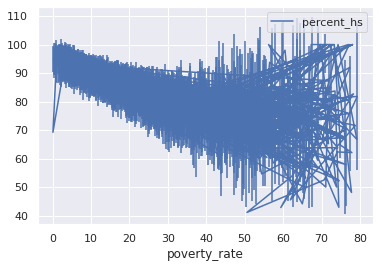

In [30]:
ax = poverty.plot(kind='line', x='poverty_rate', y='percent_hs', yerr='std_hs')

I will repeat this excercise after clipping these features and scaling them as well as the other ones. It looks as though there are some artifacts in this relationship. 

Next, I have done some merging of various tables to get most of my features into one combined table; there were some issues with merging in the police shooting incidents by State and City and I'm still not done investigating the reasons for those issues. But for now, I will examine the raw variables of ethnicity shares and medium income etc. 

In [32]:
%%bigquery city_features
SELECT
  *
FROM
  police_brutality.combined_wo_killings


In [33]:
city_features.head()

,State,City,poverty_rate,percent_completed_hs,Median_Income,share_white,share_black,share_native_american,share_asian,share_hispanic
0,AK,Birch Creek CDP,100.0,0.0,NaN,0.0,0.0,100.0,0.0,0.0
1,AK,Ferry CDP,100.0,100.0,NaN,97.0,0.0,0.0,0.0,0.0
2,AZ,Tat Momoli CDP,100.0,0.0,NaN,10.0,0.0,60.0,0.0,30.0
3,AZ,Topock CDP,100.0,100.0,NaN,100.0,0.0,0.0,0.0,0.0
4,AZ,Vaiva Vo CDP,100.0,50.0,NaN,0.0,0.8,97.7,0.0,0.8


In [34]:
city_features.describe()

,poverty_rate,percent_completed_hs,Median_Income,share_white,share_black,share_native_american,share_asian,share_hispanic
count,27823.000000,27827.000000,27241.000000,27999.000000,27999.000000,27999.000000,27999.000000,27999.000000
mean,16.179323,85.945312,51318.858669,83.224390,6.904732,2.785499,1.582496,9.140330
std,12.680797,11.436781,25554.677080,21.553015,15.622831,12.429889,4.353750,17.084784
min,0.000000,0.000000,2500.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,7.200000,81.300000,35625.000000,78.500000,0.200000,0.100000,0.000000,1.200000
50%,13.600000,88.500000,45304.000000,92.500000,0.800000,0.300000,0.400000,2.900000
75%,22.200000,93.500000,59500.000000,96.900000,4.400000,0.800000,1.200000,8.000000
max,100.000000,100.000000,250000.000000,100.000000,100.000000,100.000000,67.100000,100.000000


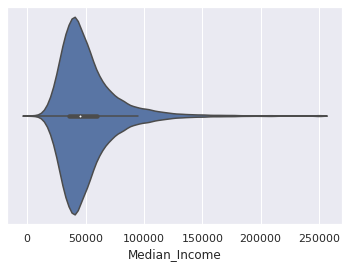

In [37]:
ax = sns.violinplot(data=city_features, x='Median_Income', inner='box', orient='h')

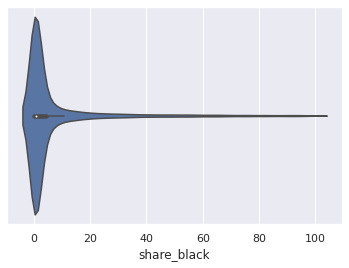

In [38]:
ax = sns.violinplot(data=city_features, x='share_black', inner='box', orient='h')

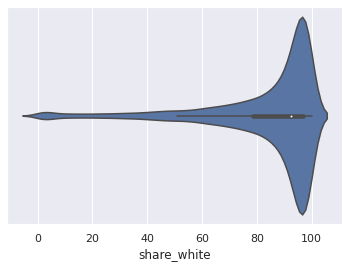

In [39]:
ax = sns.violinplot(data=city_features, x='share_white', inner='box', orient='h')

here we can see that the shares of different ethnicities look quite different 

In [41]:
%%bigquery pop_shares
SELECT
  share_white,
  AVG(share_black) AS share_black,
  STDDEV(share_black) AS std_black
FROM
  police_brutality.combined_wo_killings
GROUP BY
  share_white;

/opt/conda/lib/python3.7/site-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


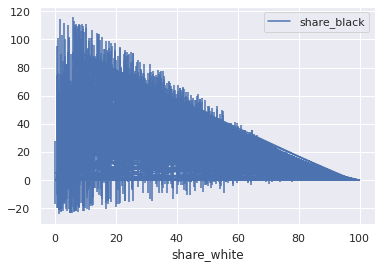

In [42]:
ax = pop_shares.plot(kind='line', x='share_white', y='share_black', yerr='std_black')

we can see here that the standard deviation of the share of black people is a decreasing function of the share of white people

Now I'm going to focus on police shootings

In [43]:
%%bigquery killings
SELECT
  *
FROM
  police_brutality.PoliceKillingsUS

In [44]:
killings.describe()

,id,age
count,2458.000000,2458.000000
mean,1424.458503,36.605370
std,790.000246,13.030774
min,3.000000,6.000000
25%,749.250000,26.000000
50%,1421.500000,34.000000
75%,2096.750000,45.000000
max,2822.000000,91.000000


In [45]:
killings.head()

,id,name,date,manner_of_death,armed,age,gender,race,City,Geographic_Area,signs_of_mental_illness,threat_level,flee,body_camera
0,131,John Martin Whittaker,2008-02-15,shot,gun,33,M,W,Anchorage,AK,False,attack,Car,False
1,836,Tristan Vent,2008-09-15,shot,gun,19,M,N,Fairbanks,AK,False,attack,Not fleeing,False
2,816,Vincent J. Perdue,2009-09-15,shot,gun,33,M,N,Fairbanks,AK,False,attack,Car,False
3,1255,Vincent Nageak,2010-02-16,shot,gun,36,M,N,Barrow,AK,False,attack,Not fleeing,False
4,1305,Patricia Kruger,2021-02-16,shot,gun,38,F,N,Houston,AK,False,attack,Not fleeing,False


In [46]:
killings['body_camera'].unique()

array([False,  True])

In [47]:
killings['flee'].unique()

array(['Car', 'Not fleeing', 'Foot', 'Other', ''], dtype=object)

it looks as though '' is a missing value and here we can likely engineer some interesting features

In [48]:
killings['threat_level'].unique()

array(['attack', 'other', 'undetermined'], dtype=object)

In [121]:
killings['race'].unique()

array(['W', 'N', '', 'B', 'H', 'A', 'O'], dtype=object)

Let's look at this variable via a histogram

In [120]:
alt.Chart(killings).mark_bar(
    cornerRadiusTopLeft=0,
    cornerRadiusTopRight=0
).encode(
    x='Geographic_Area:O',
    y='count():Q',
    color='race:N'
)

alt.Chart(...)

clearly we have to divide the killings by the population of each state from the 2010 census (which I will merge using BigQuery) to normalize this histogram so that we control for the sheer number of people living in a state. We will also have the feature for the shares of ethnicities of course and this shall control for the fact that different states have different proportions of various ethnicities.  For example, if we wanted to know how race biased these shootings are likely to be, we must know how likely an officer is to encounter a person with a given ethnicity.  We would also want this same feature by city rather than by state and I will prepare such a feature, but the resulting histogram is rather large to look at. 

In [129]:
%%bigquery killings
WITH state_pop AS (SELECT
  state_code,
  SUM(cens.population) AS state_pop
FROM
  bigquery-public-data.census_bureau_usa.population_by_zip_2010 AS cens
JOIN
  bigquery-public-data.utility_us.zipcode_area AS code
ON
  code.zipcode=cens.zipcode
  WHERE cens.minimum_age is null AND cens.maximum_age is null AND cens.gender is null
GROUP BY 
  state_code)

SELECT sp.state_code as state, City, name,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera, sp.state_pop FROM police_brutality.PoliceKillingsUS as k JOIN state_pop as sp ON sp.state_code = k.Geographic_Area

In [134]:
killings[killings['state']=="NY"]

,state,City,name,date,manner_of_death,armed,age,gender,race,signs_of_mental_illness,threat_level,flee,body_camera,state_pop
1551,NY,New City,Vincent Cordaro,2008-02-15,shot,gun,57,M,W,True,attack,Not fleeing,False,19377841
1552,NY,Clarendon,James Ellis,2021-03-15,shot,gun,44,M,W,False,attack,Car,False,19377841
1553,NY,Queens,Jonathan Efraim,2022-04-15,shot,gun,30,M,W,True,attack,Foot,False,19377841
1554,NY,Constantia,David Schwalm,2008-05-15,shot,gun,58,M,W,True,attack,Not fleeing,False,19377841
1555,NY,Queens,Dalton Branch,2026-05-15,shot,gun,51,M,B,False,attack,Not fleeing,False,19377841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1590,NY,Middletown,Richard G. Dinneny,2013-07-16,shot,toy weapon,56,M,W,True,other,Not fleeing,False,19377841
1591,NY,New York,Sergio Reyes,2019-02-17,shot,toy weapon,18,M,H,False,attack,Foot,False,19377841
1592,NY,New York,Jahlire Nicholson,2014-01-17,shot and Tasered,screwdriver,28,M,B,False,attack,Not fleeing,False,19377841
1593,NY,Bronx,Deborah Danner,2018-10-16,shot,baseball bat,66,F,B,True,attack,Not fleeing,False,19377841


As you can see, BigQuery stores a lot of useful data sets in its public data project and can conveniently be pulled in. 

In [150]:
kill_by_eth = killings.groupby(['state', 'race','state_pop']).size().reset_index(name='counts')

In [152]:
kill_by_eth[kill_by_eth['state']=='CA']

,state,race,state_pop,counts
15,CA,,37249542,29
16,CA,A,37249542,14
17,CA,B,37249542,64
18,CA,H,37249542,165
19,CA,N,37249542,1
20,CA,O,37249542,8
21,CA,W,37249542,123


In [168]:
kill_by_eth['normed_pop']=kill_by_eth['state_pop']/min(kill_by_eth['state_pop'].astype(float))

In [171]:
kill_by_eth['count_by_pop']=kill_by_eth['counts']/kill_by_eth['normed_pop']

In [172]:
kill_by_eth

,state,race,state_pop,counts,count_by_pop,normed_pop
0,AK,,709930,1,0.791,1.264
1,AK,B,709930,1,0.791,1.264
2,AK,N,709930,6,4.747,1.264
3,AK,W,709930,7,5.538,1.264
4,AL,,4779588,1,0.118,8.510
...,...,...,...,...,...,...
177,WV,W,1852774,20,6.063,3.299
178,WY,,561662,1,1.000,1.000
179,WY,H,561662,1,1.000,1.000
180,WY,N,561662,1,1.000,1.000


In [173]:
kill_by_eth[kill_by_eth['state']=='CA']

,state,race,state_pop,counts,count_by_pop,normed_pop
15,CA,,37249542,29,0.437,66.320
16,CA,A,37249542,14,0.211,66.320
17,CA,B,37249542,64,0.965,66.320
18,CA,H,37249542,165,2.488,66.320
19,CA,N,37249542,1,0.015,66.320
20,CA,O,37249542,8,0.121,66.320
21,CA,W,37249542,123,1.855,66.320


In [184]:
alt.Chart(kill_by_eth).mark_bar(
    cornerRadiusTopLeft=0,
    cornerRadiusTopRight=0
).encode(
    x='state:O',
    y='count_by_pop:Q',
    color='race:N'
)

alt.Chart(...)

In [185]:
kill_by_eth.describe()

,state_pop,counts,count_by_pop,normed_pop
count,182.000,182.000,182.000,182.000
mean,8002100.159,13.011,1.340,14.247
std,8275048.706,20.465,1.606,14.733
min,561662.000,1.000,0.015,1.000
25%,2865765.750,2.000,0.195,5.102
50%,5301349.000,5.000,0.738,9.439
75%,9687711.000,18.000,1.910,17.248
max,37249542.000,165.000,9.334,66.320


Now we see that this looks quite different; relative to its population size, there aren't as many shootings in California as when compared to its absolute number of shootings. I also divided the population of each state by the population of the smallest state for normalization. Relative to their sizes, we can see that Alaska, New Mexico, Arizona and Oklahoma have a lot of police shootings. We don't yet know the relative biases becaue we haven't yet considered the ethic shares of those states, which will be additional features and we can do interactions with those. 